# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from mad4pg import MAD4PG

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.09000000171363354


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
def train(check_pt_path,n_episodes=10000,isSolve=True):
    """Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    
    avgscores=[]
    scores=[]
    scores1 = []
    scores2 = []# list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states= env_info.vector_observations
        score1 = 0
        score2 = 0
        reward_done_history = []
        while True:
            actions = multiagent.acts(states)
            env_info=env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            multiagent.step(states,actions, rewards, next_states, dones)
            states = next_states
            score1 += rewards[0]
            score2 += rewards[1]
            reward_done_history.append((rewards,dones))
            if dones[0]:
                atleast_one_reward_is_negative = rewards[0]<0 or rewards[1]<0
                both_agents_are_done = dones[0] and dones[1]
                break
            else:
                both_rewards_are_positive = rewards[0]>=0 and rewards[1]>=0
                both_agents_are_not_done = (not dones[0]) and (not dones[1])
        score=max(score1,score2)        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        scores1.append(score1)
        scores2.append(score2)
        print('\rEpisode {}\tAverage Score: {:.6f}'.format(i_episode, np.mean(scores_window)), 
              end=("."*(i_episode%10)+" "*(10-(i_episode%10))))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.6f}'.format(i_episode, np.mean(scores_window)))
            avgscores.append(np.mean(scores_window))
        if np.mean(scores_window)>0.5 and isSolve:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.6f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(multiagent.mad4pg_agent[0].actor_local.state_dict(),check_pt_path+'_actor1_solved.pth')
            torch.save(multiagent.mad4pg_agent[1].actor_local.state_dict(),check_pt_path+'_actor2_solved.pth')
            isSolve=False
    torch.save(multiagent.mad4pg_agent[0].actor_local.state_dict(),check_pt_path+'_actor1_last.pth')
    torch.save(multiagent.mad4pg_agent[1].actor_local.state_dict(),check_pt_path+'_actor2_last.pth')
    return scores,scores1,scores2


In [7]:
# train multi agent with D4PG
multiagent=MAD4PG(24,2,32,buffer_size = int(1e6),batch_size = 64,gamma = 0.99,tau = 1e-2,update_every = 4,num_mc_steps=5)
scores,scores1,scores2 = train(check_pt_path='trained_agent',n_episodes=10000)

Episode 100	Average Score: 0.002800          
Episode 200	Average Score: 0.000000          
Episode 300	Average Score: 0.000000          
Episode 400	Average Score: 0.000000          
Episode 500	Average Score: 0.031900          
Episode 600	Average Score: 0.037700          
Episode 700	Average Score: 0.035200          
Episode 800	Average Score: 0.015200          
Episode 900	Average Score: 0.006700          
Episode 1000	Average Score: 0.014100          
Episode 1100	Average Score: 0.055600          
Episode 1200	Average Score: 0.046500          
Episode 1300	Average Score: 0.000000          
Episode 1400	Average Score: 0.000000          
Episode 1500	Average Score: 0.035500          
Episode 1600	Average Score: 0.049400          
Episode 1700	Average Score: 0.054100          
Episode 1800	Average Score: 0.117600          
Episode 1900	Average Score: 0.095000          
Episode 2000	Average Score: 0.086600          
Episode 2100	Average Score: 0.078700          
Episode 2200	Average S

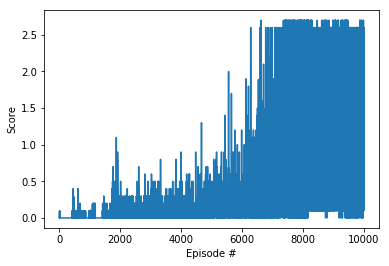

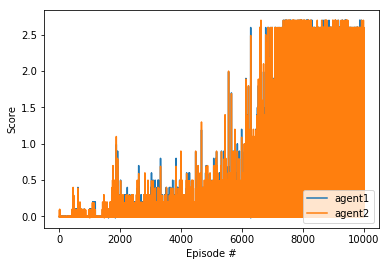

In [8]:

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores1)), scores1)
plt.plot(np.arange(len(scores2)), scores2)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['agent1', 'agent2'], loc='lower right')
plt.show()
